Import all of the necessary packages

In [193]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso



from sklearn.preprocessing import StandardScaler 

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = [12, 8]

In [170]:
#Import the galaxies data frame
galaxies = pd.read_csv('galaxies.csv')
galaxies.describe()

,Seq,ra,dec,x,y,Rmag,e_Rmag,Ap_Rmag,ApD_Rmag,mu_max,...,UF_G,e_UF_G,BF_D,e_BF_D,VF_D,e_VF_D,RF_D,e_RF_D,IF_D,e_IF_D
count,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,...,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000,14283.000000
mean,32031.989988,53.103185,-27.812231,3996.990690,3822.679154,22.877013,0.044602,23.299326,-0.480696,23.551996,...,0.025709,0.003006,0.033998,0.001823,0.047404,0.001736,0.067190,0.000776,0.085599,0.004945
std,18067.286515,0.168712,0.144062,2257.907307,2179.420643,1.106667,0.026406,0.996280,0.513395,0.941022,...,0.037537,0.000744,0.082987,0.000696,0.144851,0.000838,0.203895,0.000622,0.243303,0.002589
min,28.000000,52.808610,-28.065162,2.755915,2.329053,10.765173,0.000000,17.549747,-14.357697,17.722456,...,-0.010006,0.002142,-0.003222,0.001185,-0.002703,0.001203,0.000799,0.000537,0.000088,0.003372
25%,16137.000000,52.959550,-27.940175,2036.078300,1884.456550,22.422863,0.023800,22.842112,-0.652856,23.133142,...,0.010468,0.002558,0.011730,0.001485,0.014404,0.001456,0.019037,0.000643,0.022475,0.004069
50%,32464.000000,53.098921,-27.807209,4053.147200,3901.554700,23.217447,0.043000,23.524193,-0.367838,23.745733,...,0.017856,0.002825,0.018375,0.001666,0.021272,0.001599,0.027609,0.000696,0.037212,0.004512
75%,47408.500000,53.249622,-27.689810,5922.515250,5675.447500,23.680439,0.061600,23.927407,-0.173506,24.170527,...,0.028107,0.003209,0.029574,0.001958,0.035663,0.001812,0.051726,0.000768,0.071960,0.005156
max,63501.000000,53.401884,-27.564573,7929.383000,7562.462000,23.999872,0.162300,27.370026,0.774403,25.797379,...,0.881718,0.022348,2.613236,0.021201,5.022725,0.029392,6.771044,0.024034,7.837279,0.092711


In [171]:
#split the galaxies data frame into seven smaller data frames
mags = pd.DataFrame([galaxies['UjMag'],galaxies['BjMag'],galaxies['VjMag'],galaxies['usMag'],
                galaxies['gsMag'],galaxies['rsMag'],galaxies['S280Mag']])
mags = mags.transpose()

Rband = pd.DataFrame([galaxies['Rmag'], galaxies['Ap_Rmag'],galaxies['e_Rmag'], galaxies['ApD_Rmag'], galaxies['mu_max']])
Rband = Rband.transpose()

magsErr = pd.DataFrame([galaxies['e_UjMag'],galaxies['e_BjMag'],galaxies['e_VjMag'],galaxies['e_usMag'],
                galaxies['e_gsMag'],galaxies['e_rsMag'],galaxies['e_S280Mag']])
magsErr = magsErr.transpose()

metadata = pd.DataFrame([galaxies['ra'],galaxies['dec'],galaxies['x'],galaxies['y']
                         ,galaxies['MC_class'],galaxies['MC_z_ml']])
metadata = metadata.transpose()

flux_filter = [col for col in galaxies if col.startswith('W') or col.startswith('UF') or col.startswith('BF')
              or col.startswith('VF') or col.startswith('RF') or col.startswith('IF')]
flux = galaxies[flux_filter]

fluxErr_filter = [col for col in galaxies if col.startswith('e_W') or col.startswith('e_UF') or col.startswith('e_BF')
              or col.startswith('e_VF') or col.startswith('e_RF') or col.startswith('e_IF')]
fluxErr = galaxies[fluxErr_filter]

redshift = pd.DataFrame([galaxies['MC_z'], galaxies['e_MC_z'],
                     galaxies['chi2red'], galaxies['e_MC_z']/galaxies['MC_z']])
redshift = redshift.transpose()
redshift.columns = ['MC_z','e_MC_z','chi2red','e_Frac_z']

In [172]:
#create the X dataframe using the magnitudes, magnitude errors, 
# photon fluxes, and photon flux errors
X = pd.concat([mags, magsErr, flux, fluxErr], axis=1, sort=False)
X.head()

,UjMag,BjMag,VjMag,usMag,gsMag,rsMag,S280Mag,e_UjMag,e_BjMag,e_VjMag,...,e_W696F_E,e_W753F_E,e_W815F_E,e_W856F_D,e_W914F_D,e_UF_G,e_BF_D,e_VF_D,e_RF_D,e_IF_D
0,-20.369415,-20.828274,-21.658553,-20.512117,-21.075179,-22.083709,-21.257235,3.334810,3.334810,3.334810,...,0.004394,0.005561,0.009306,0.008028,0.006120,0.003244,0.002633,0.001246,0.000662,0.003372
1,-19.150250,-18.206184,-18.623569,-19.282882,-18.322248,-18.899932,-19.154557,0.160315,1.367350,1.367350,...,0.002933,0.004785,0.006142,0.007965,0.006429,0.002685,0.001465,0.001300,0.000736,0.005000
2,-17.913065,-18.407511,-19.337878,-18.020763,-18.716319,-19.819038,-17.401262,0.113077,0.113077,0.134553,...,0.003080,0.006888,0.008415,0.007814,0.007494,0.002713,0.001487,0.002241,0.000947,0.004435
3,-19.849175,-19.536735,-19.752779,-20.040451,-19.606571,-20.030117,-20.246551,0.104143,0.136624,0.136624,...,0.003538,0.005026,0.010296,0.008453,0.006943,0.002933,0.001638,0.001603,0.000813,0.004949
4,-12.193742,-12.597335,-13.461531,-12.311554,-12.989203,-13.844666,-11.876799,0.169750,0.164703,0.116170,...,0.003636,0.005523,0.006051,0.007273,0.007858,0.003441,0.001649,0.001820,0.000775,0.006196


In [173]:
#make the y dataframe from the target redshifts
y = redshift['MC_z']
y.head()

0    1.530428
1    0.870229
2    0.642983
3    0.829822
4    0.105104
Name: MC_z, dtype: float64

In [174]:
#plit the training and testing sets, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

The test r2 score is 0.98270


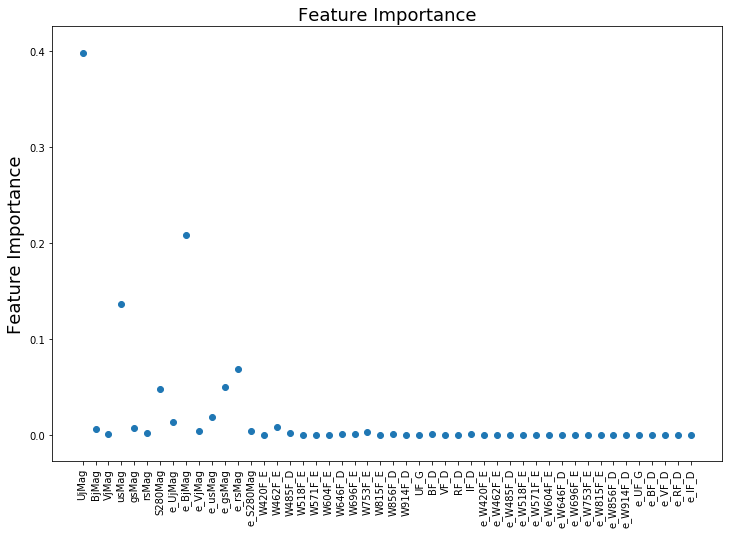

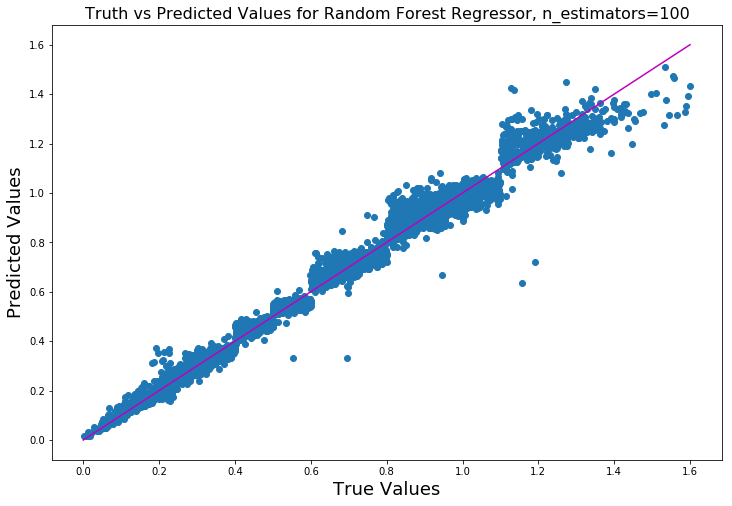

In [194]:
#try a sample random forest regressor, randomly choose n_estimators=100
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
print('The test r2 score is {:.5f}'.format(r2_score(y_test, y_pred)))

plt.scatter(np.arange(1,len(reg.feature_importances_)+1),reg.feature_importances_)
plt.xticks(np.arange(1,len(reg.feature_importances_)+1),X_train.columns.values, rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance', fontsize=18)
plt.show()

plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Random Forest Regressor, n_estimators=100',fontsize=18)
plt.show()

0.7368445580708708


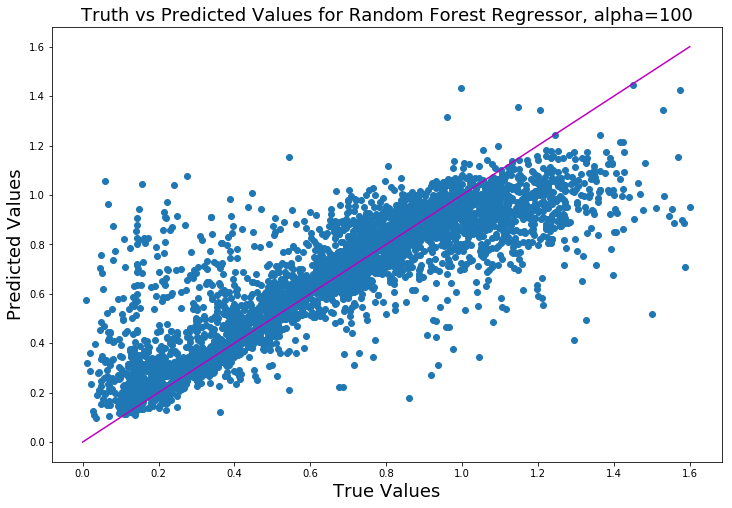

0.7325706377239392


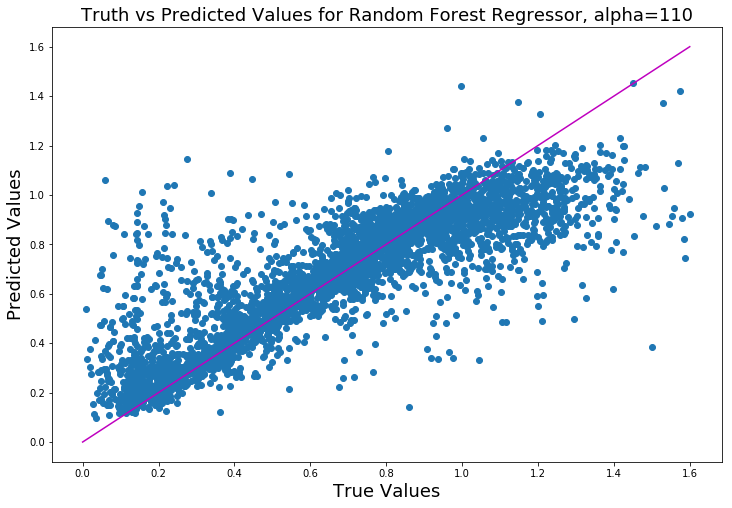

0.7324382979140256


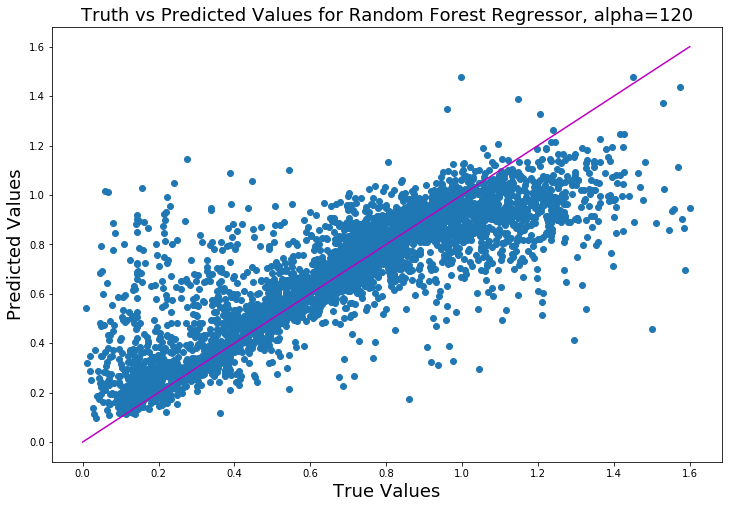

0.7335674308716955


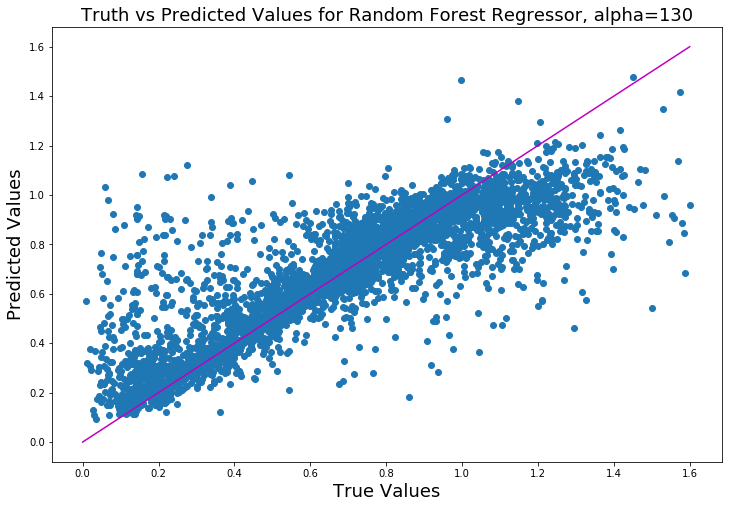

0.7329934876853952


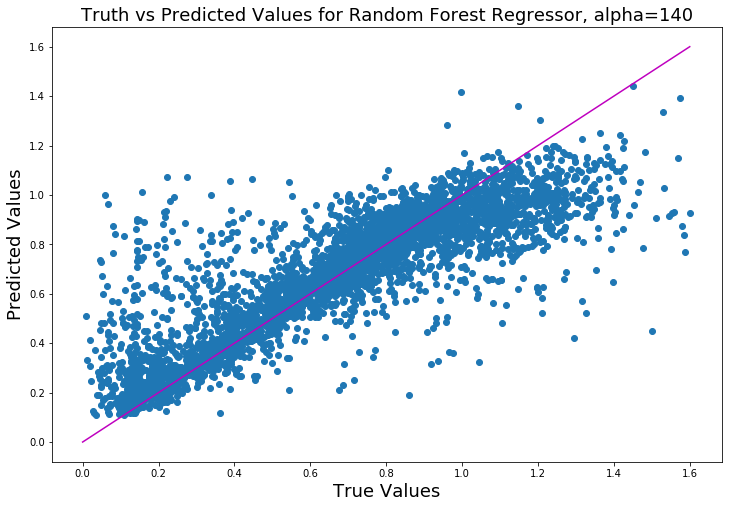

0.7350621738704874


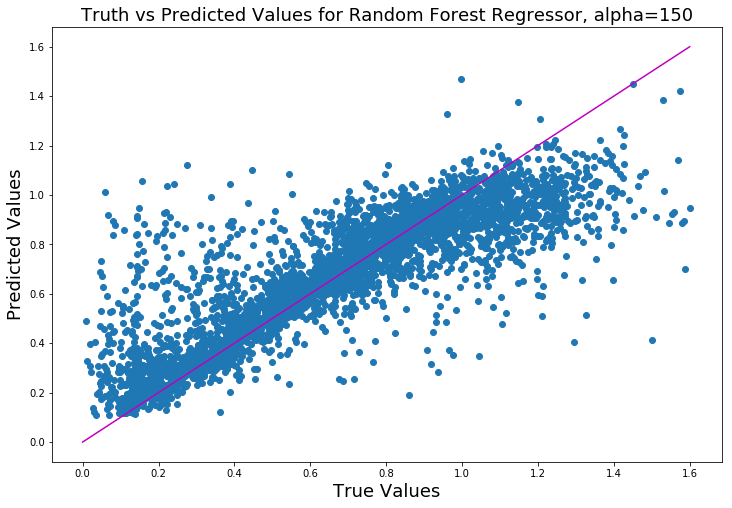

0.7347378244373952


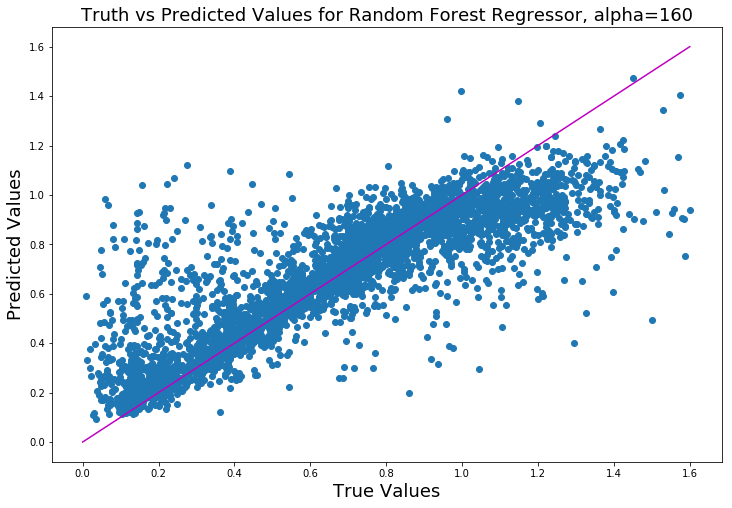

0.733954258341122


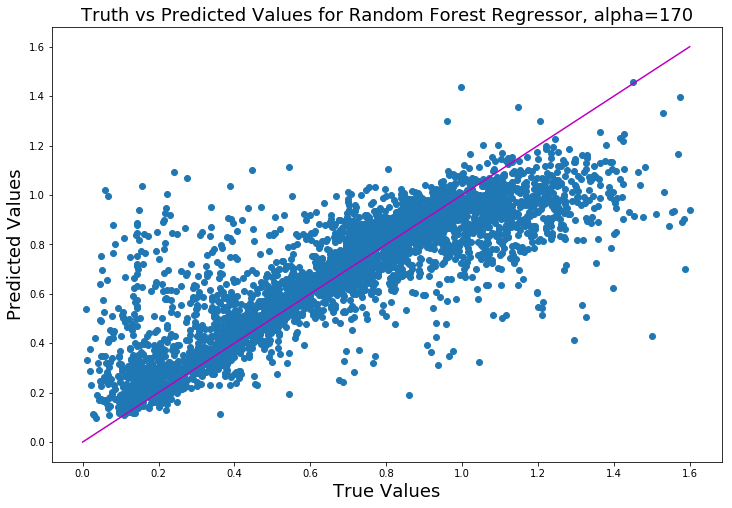

0.7344775463090828


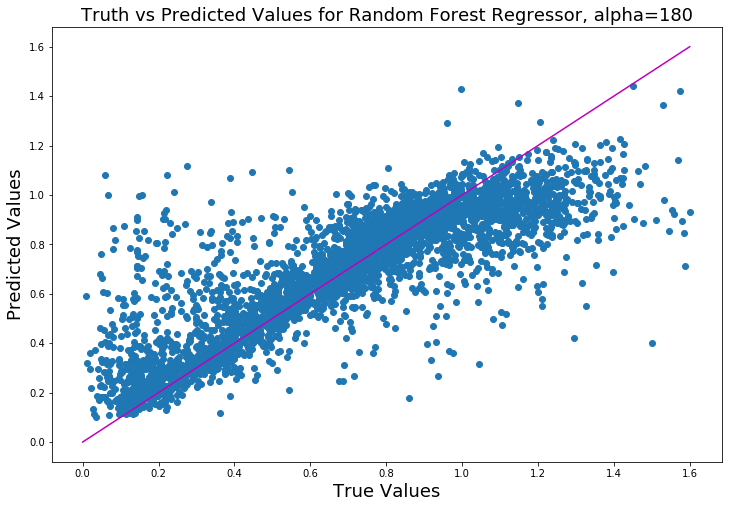

0.736378373968341


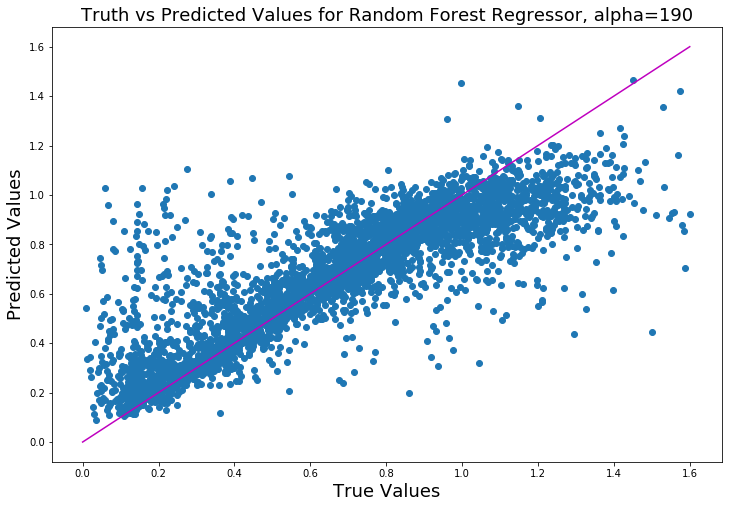

0.7333720990152689


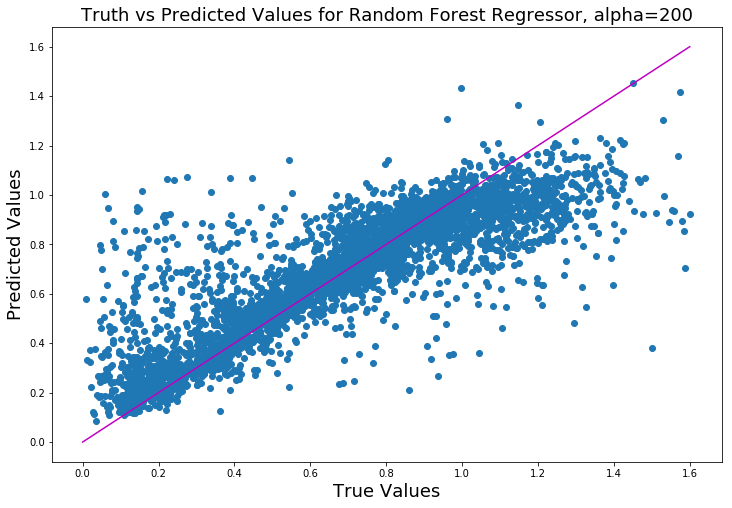

0.7355645431864287


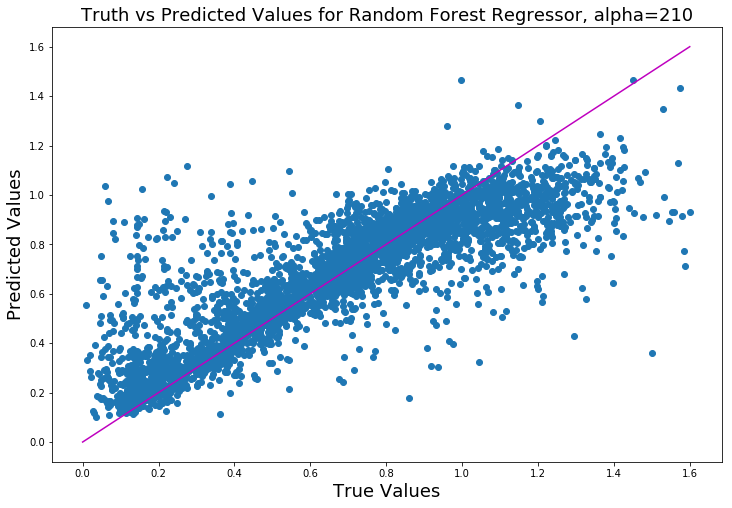

0.7335313111274184


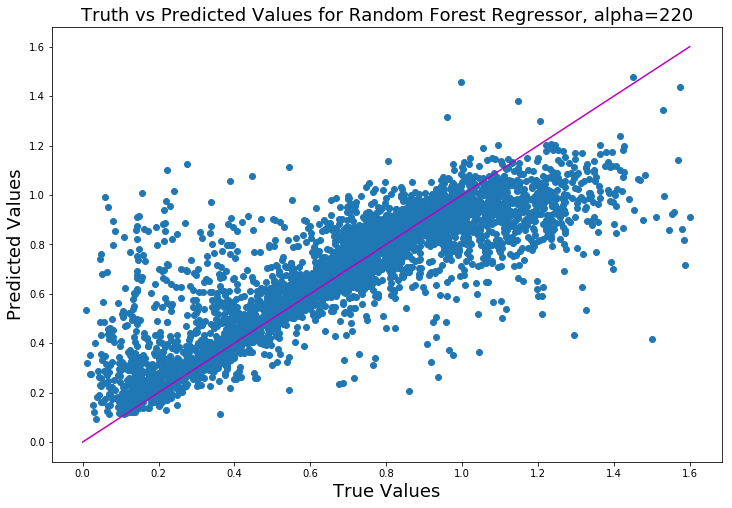

0.7350485740799169


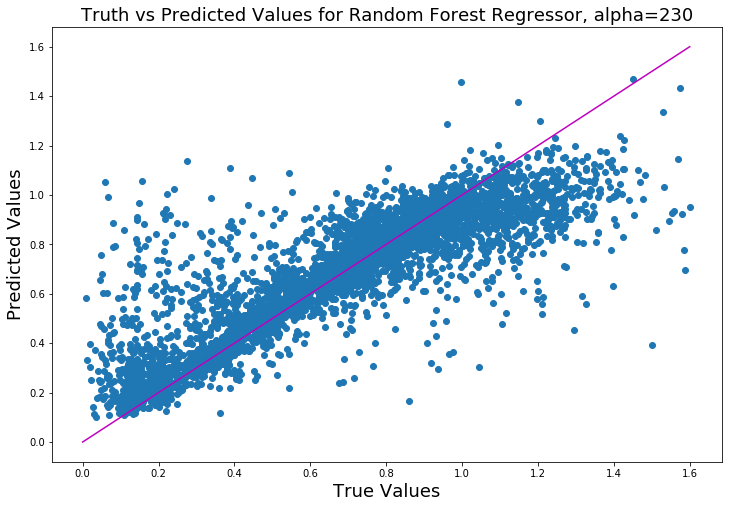

0.734271680432131


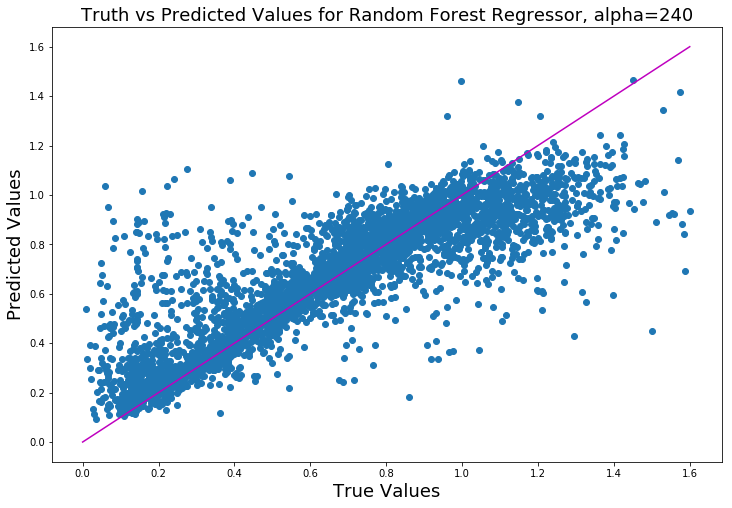

0.7348738571137119


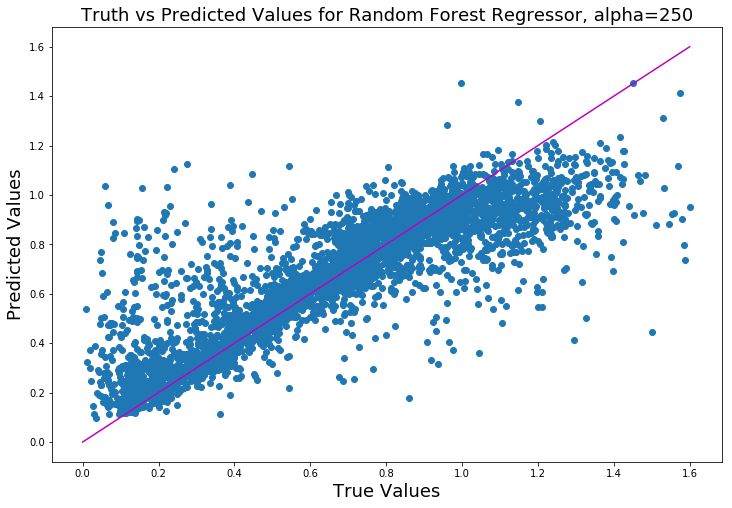

0.7343925972932328


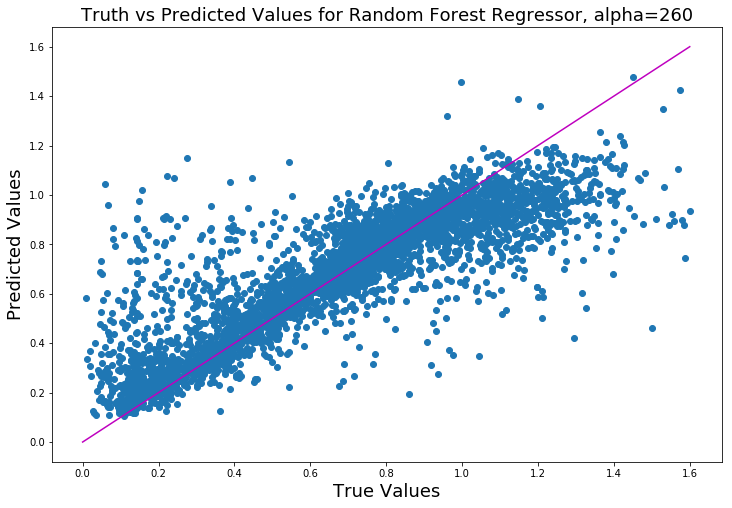

0.734991244484664


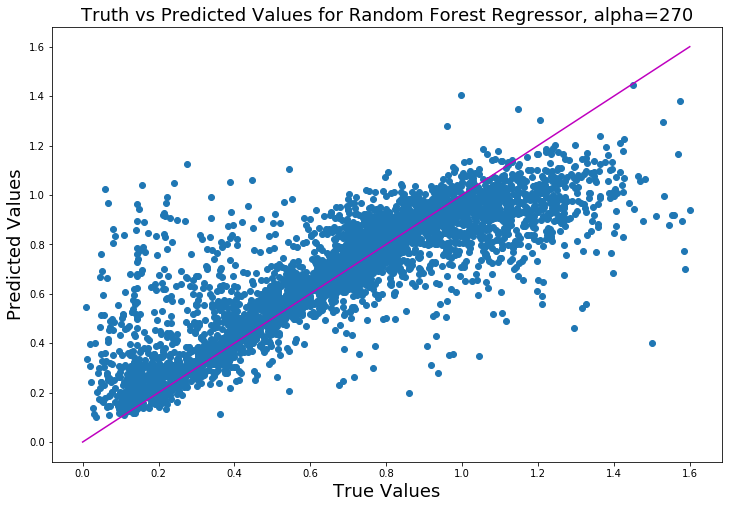

0.7335095842242407


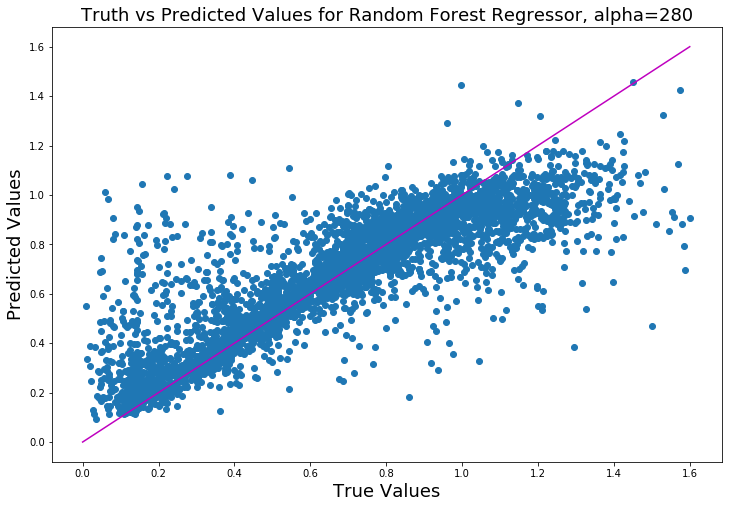

0.7347369465192366


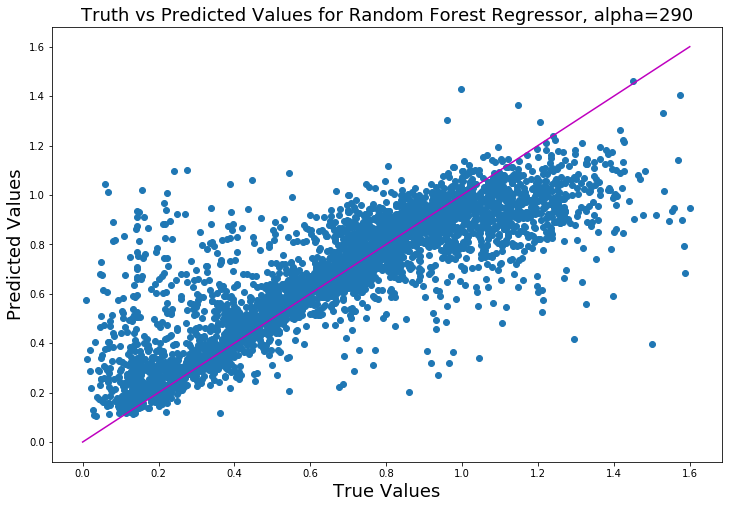

The best model is n = 100.00000 and r2 = 0.73684


In [236]:
#look at graphs of a range of n_estimators
best_n = 0
best_r2 = 0

for n in range(100,300,10):
    reg = RandomForestRegressor(n_estimators=n)
    reg.fit(X_train,y_train)

    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(r2)
    
    if r2 > best_r2:
        best_r2 = r2
        best_n = n

    plt.scatter(y_test, y_pred)
    plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
    plt.xlabel('True Values',fontsize=18)
    plt.ylabel('Predicted Values',fontsize=18)
    plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha={}'.format(n),fontsize=18)
    plt.show()


print('The best model is n = {:.5f} and r2 = {:.5f}'.format(best_n, best_r2))

The best number of estimators is 220

In [237]:
#do a parameter search to find the max_depth
param_grid = {
    'max_depth': np.arange(11,16)
}
reg = RandomForestRegressor(n_estimators = 220)
search = GridSearchCV(reg, param_grid, cv = 5, return_train_score = False)
search.fit(X,y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.983):
{'max_depth': 15}


Running GridSearchCV consistently shows that the best parameter for the max_depth is the highest value in the given range. Therefore, I decided not to limit the max_depth

0.982181855830229


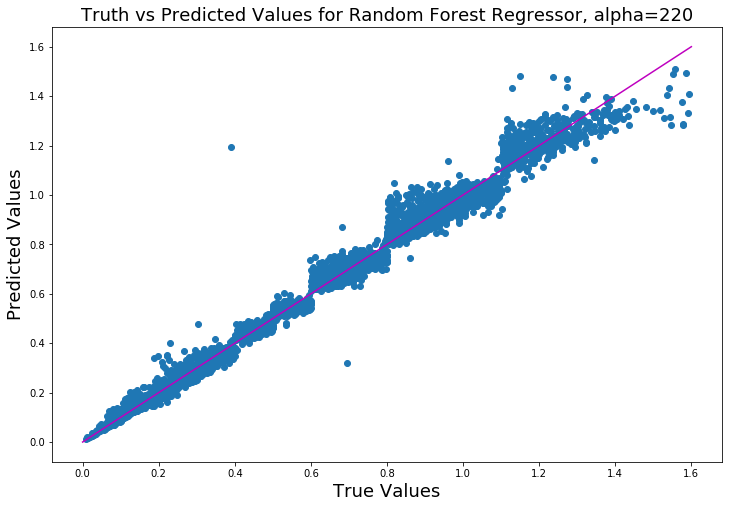

0.9832703290606419


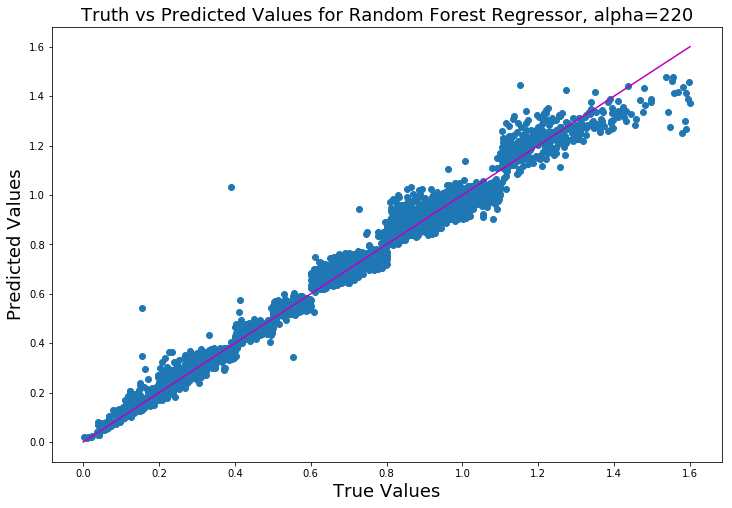

0.9821120837594317


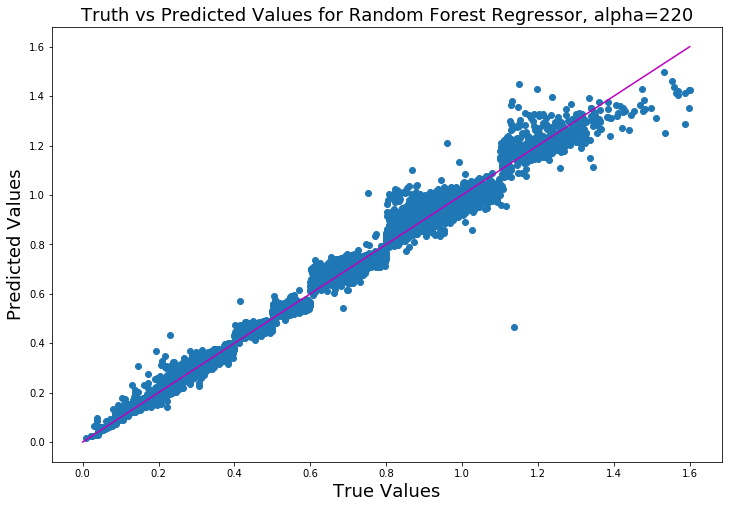

0.9825214228834342


In [238]:
#run three different random forest regressors on different splits, see consistency
r2s = []
for i in range(0,3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    reg = RandomForestRegressor(n_estimators=220)
    reg.fit(X_train,y_train)

    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(r2)
    r2s.append(r2)

    plt.scatter(y_test, y_pred)
    plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
    plt.xlabel('True Values',fontsize=18)
    plt.ylabel('Predicted Values',fontsize=18)
    plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha=220',fontsize=18)
    plt.show()


print(np.mean(r2s))


0.9669709078731391


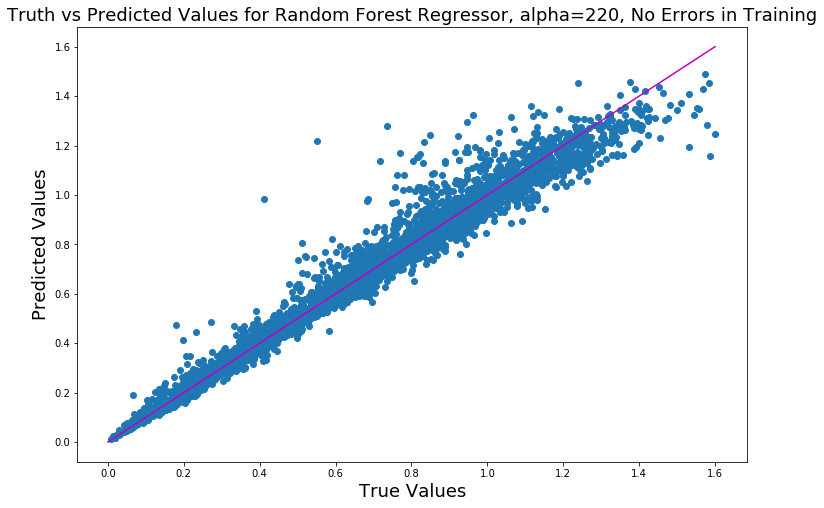

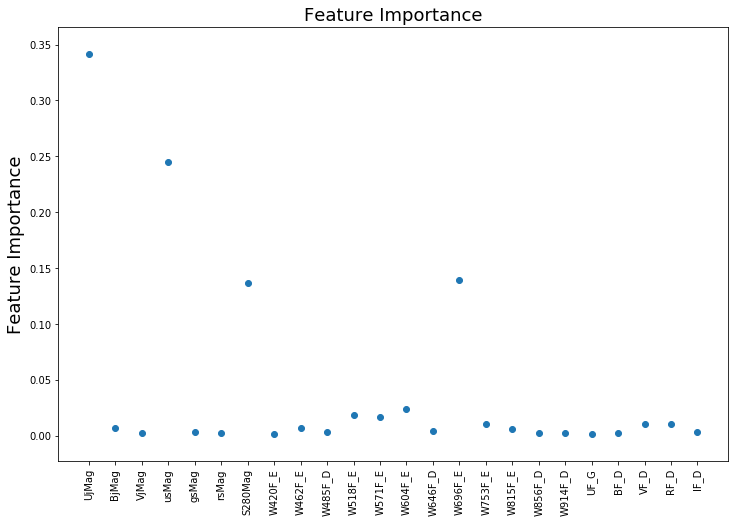

In [230]:
#test random forest w/out errors
XnoErr = pd.concat([mags, flux], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(XnoErr, y, test_size = 0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=220)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha=220, No Errors in Training',fontsize=18)
plt.show()

plt.scatter(np.arange(1,len(reg.feature_importances_)+1),reg.feature_importances_)
plt.xticks(np.arange(1,len(reg.feature_importances_)+1),X_train.columns.values, rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance', fontsize=18)
plt.show()

0.9824355567083957


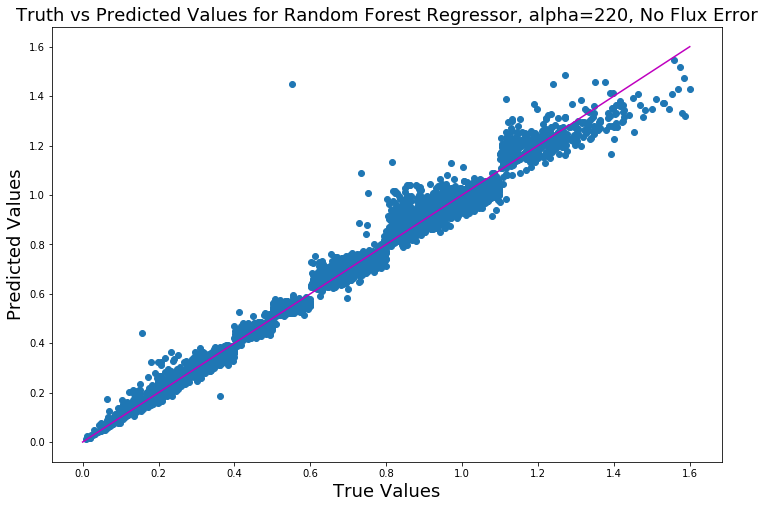

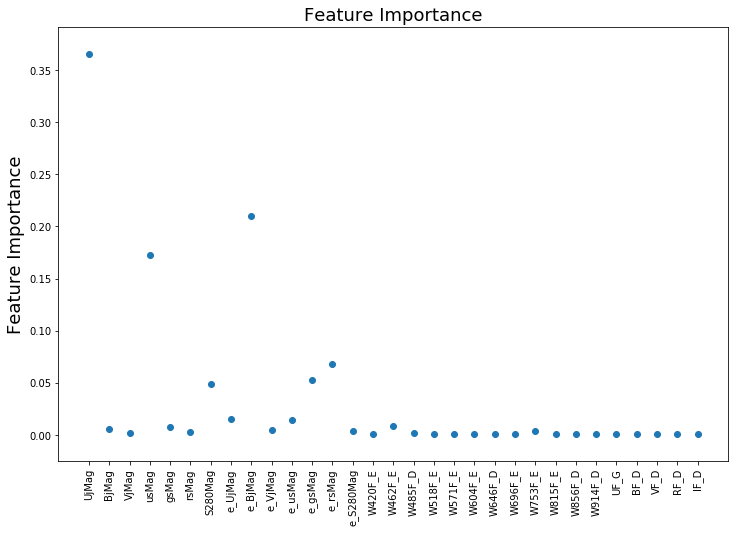

In [231]:
#test random forest w/out flux error
XnoErr = pd.concat([mags, magsErr, flux], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(XnoErr, y, test_size = 0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=220)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha=220, No Flux Error',fontsize=18)
plt.show()

plt.scatter(np.arange(1,len(reg.feature_importances_)+1),reg.feature_importances_)
plt.xticks(np.arange(1,len(reg.feature_importances_)+1),X_train.columns.values, rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance', fontsize=18)
plt.show()

Adding the magnitude error creates the steps in the scatterplot, adds accuracy

0.7347035551197871


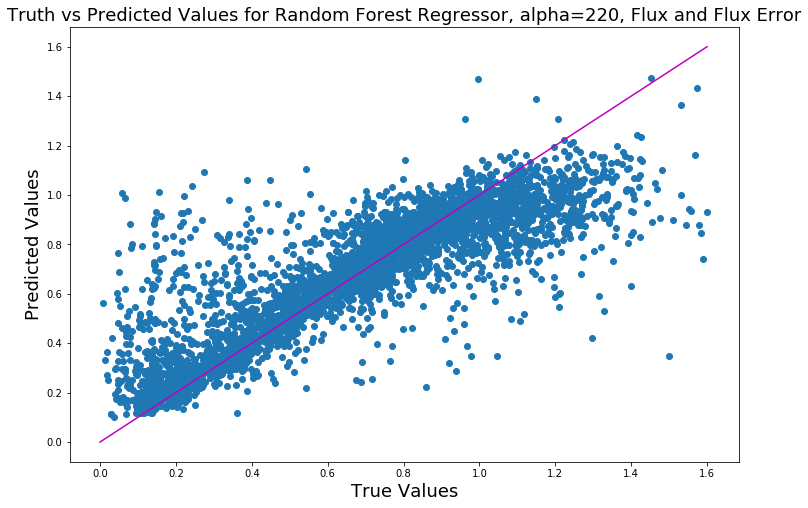

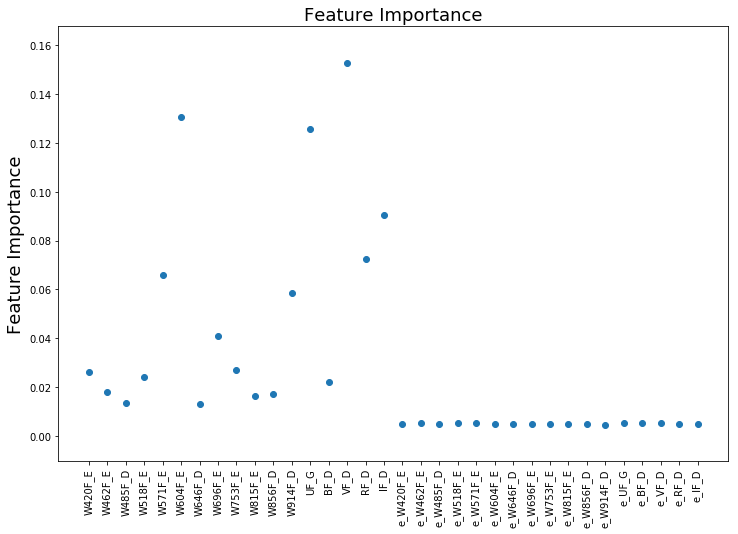

In [235]:
#test random forest w/out mags, mag errors
XFlux = pd.concat([flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(XFlux, y, test_size = 0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=220)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha=220, Flux and Flux Error',fontsize=18)
plt.show()

plt.scatter(np.arange(1,len(reg.feature_importances_)+1),reg.feature_importances_)
plt.xticks(np.arange(1,len(reg.feature_importances_)+1),X_train.columns.values, rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance', fontsize=18)
plt.show()

0.7464673608692962


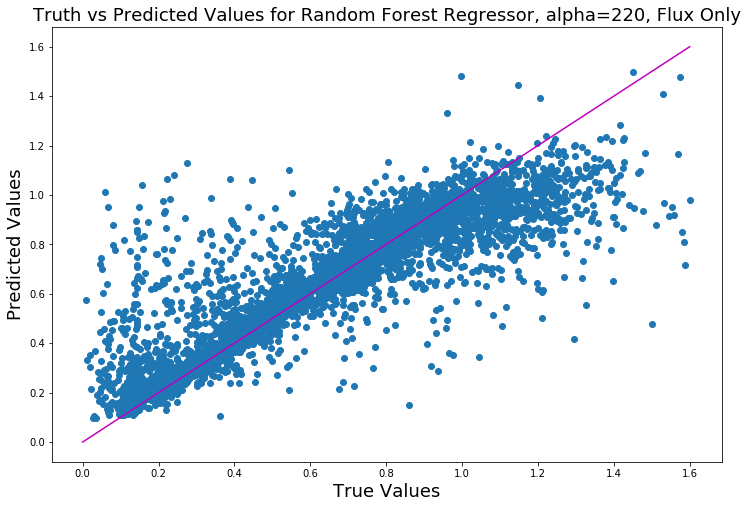

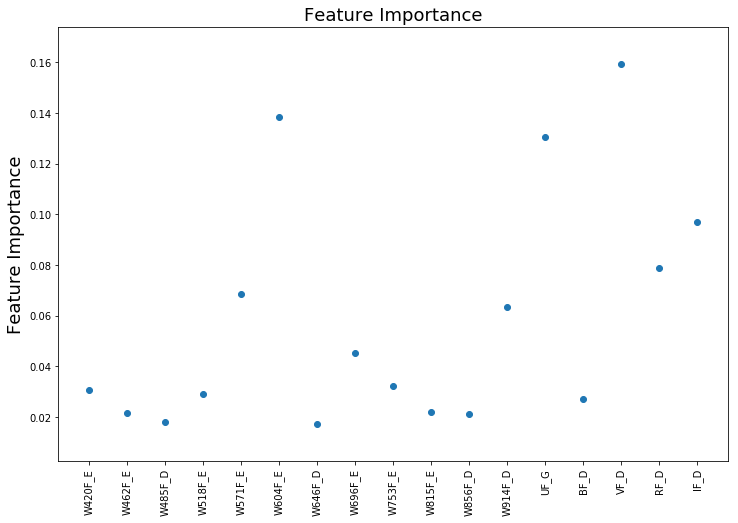

In [234]:
#test random forest w/out errors, mags
XFlux = pd.concat([flux], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(XFlux, y, test_size = 0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=220)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha=220, Flux Only',fontsize=18)
plt.show()

plt.scatter(np.arange(1,len(reg.feature_importances_)+1),reg.feature_importances_)
plt.xticks(np.arange(1,len(reg.feature_importances_)+1),X_train.columns.values, rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance', fontsize=18)
plt.show()

0.983114052195045


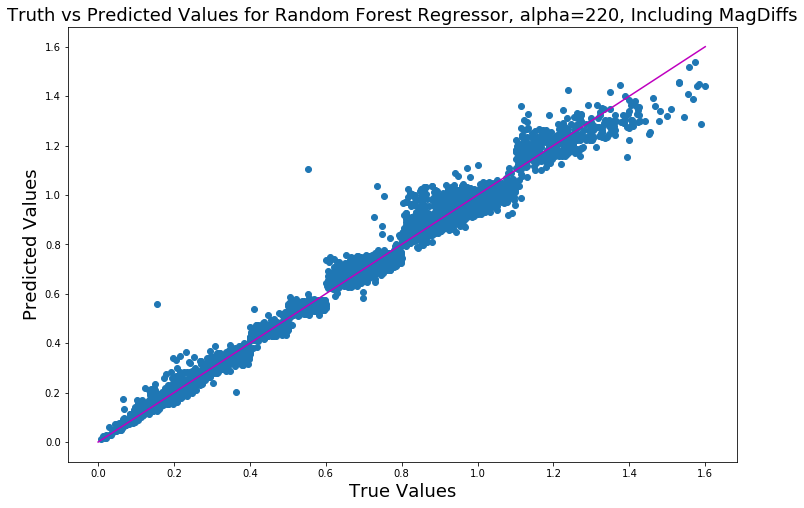

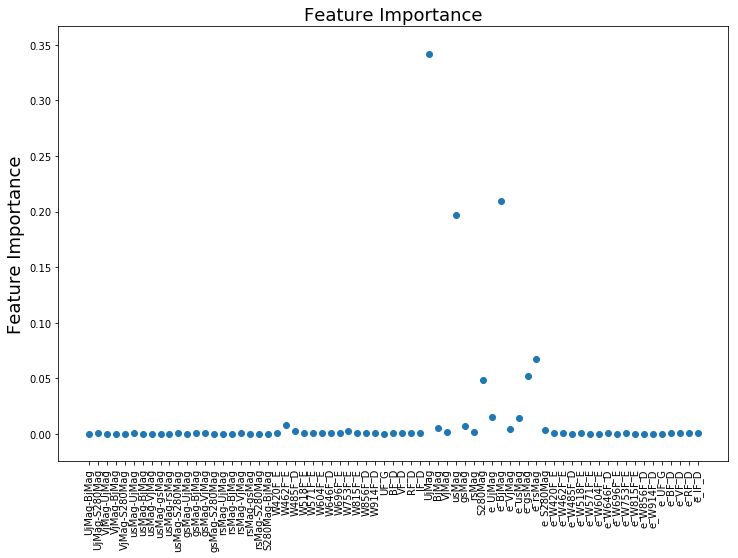

In [233]:
#try with the mag subtractions 
magDiffs = pd.DataFrame()
for column in mags:
    for column2 in mags:
        if (column > column2):
            magDiffs[column + '-' + column2] = mags[column] - mags[column2]
            
XMagDiffs = pd.concat([magDiffs, flux, mags, magsErr, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(XMagDiffs, y, test_size = 0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=220)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Random Forest Regressor, alpha=220, Including MagDiffs',fontsize=18)
plt.show()

plt.scatter(np.arange(1,len(reg.feature_importances_)+1),reg.feature_importances_)
plt.xticks(np.arange(1,len(reg.feature_importances_)+1),X_train.columns.values, rotation=90)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance', fontsize=18)
plt.show()


Magnitude subtraction does not seem to add anything meaningful 

Try SVR, both with and without magnitudes and with and without scaling

0.9346934769463481


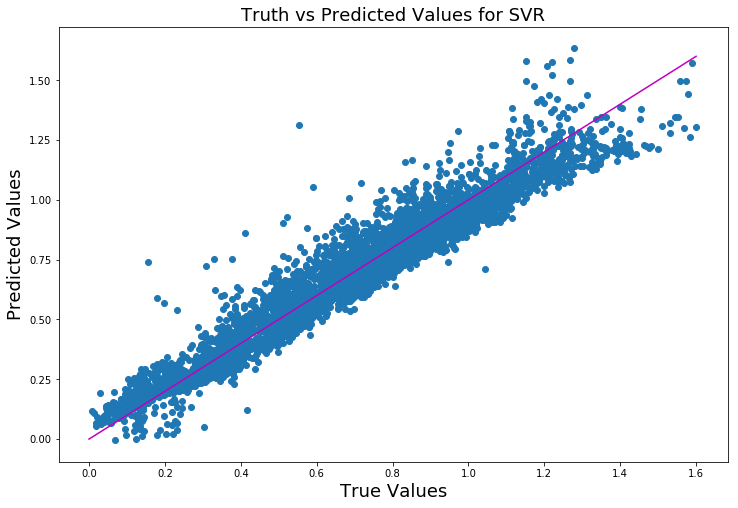

In [210]:
clf = SVR(kernel='rbf')
X = pd.concat([mags, magsErr, flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#scaler = StandardScaler()
#X_trainScale = pd.DataFrame(scaler.fit_transform(X_train))
#X_testScale = pd.DataFrame(scaler.fit_transform(X_test))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for SVR',fontsize=18)
plt.show()

0.5153342385884121


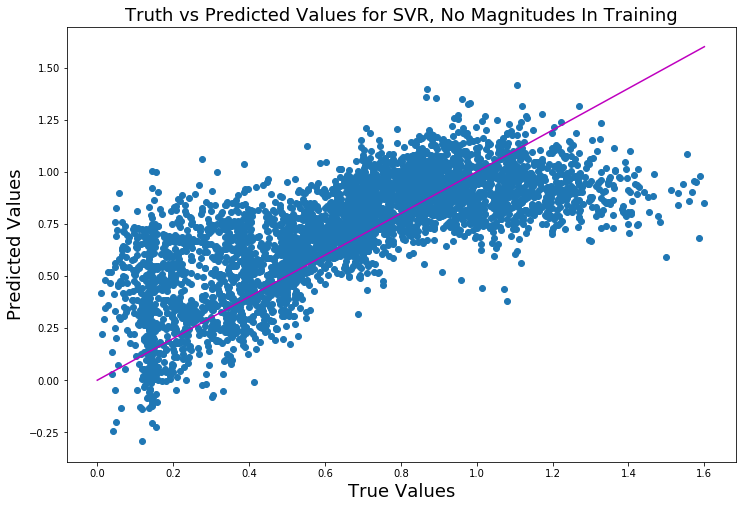

In [213]:
clf = SVR(kernel='rbf')

X = pd.concat([flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()
X_trainScale = pd.DataFrame(scaler.fit_transform(X_train))
X_testScale = pd.DataFrame(scaler.fit_transform(X_test))
clf.fit(X_trainScale, y_train)
y_pred = clf.predict(X_testScale)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for SVR, No Magnitudes In Training',fontsize=18)
plt.show()

In [94]:
#pipelines using pca before Random Forest Regression and SVR

0.9718445142534712


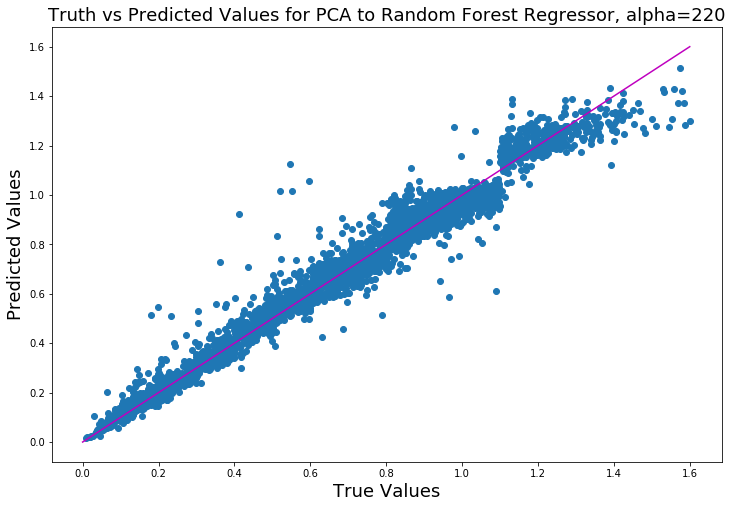

In [215]:
reg = RandomForestRegressor(n_estimators=220)
pca = PCA()

pipeline = Pipeline(steps=[('pca', pca), ('reg', reg)])
X = pd.concat([mags, magsErr, flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#scaler = StandardScaler()
#X_trainScale = pd.DataFrame(scaler.fit_transform(X_train))
#X_testScale = pd.DataFrame(scaler.fit_transform(X_test))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for PCA to Random Forest Regressor, alpha=220',fontsize=18)
plt.show()


0.6923241120869521


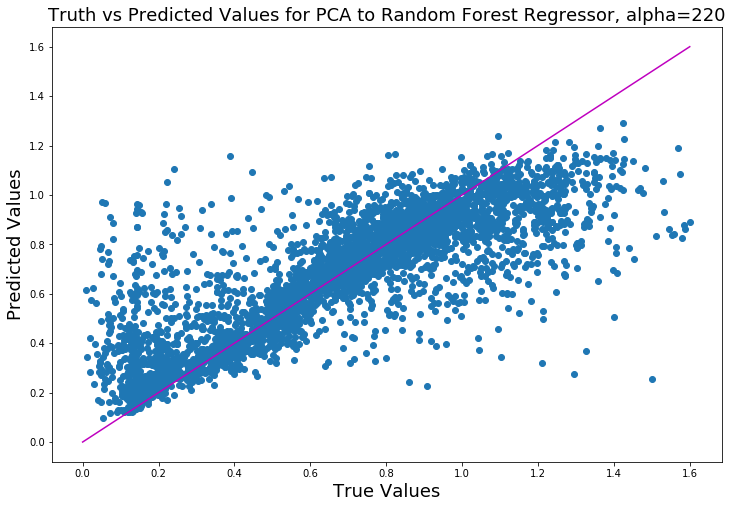

In [221]:
reg = RandomForestRegressor(n_estimators=220)
pca = PCA()

pipeline = Pipeline(steps=[('pca', pca), ('reg', reg)])
X = pd.concat([flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#scaler = StandardScaler()
#X_trainScale = pd.DataFrame(scaler.fit_transform(X_train))
#X_testScale = pd.DataFrame(scaler.fit_transform(X_test))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for PCA to Random Forest Regressor, alpha=220',fontsize=18)
plt.show()


0.9346934769463477
0.9346934769463477


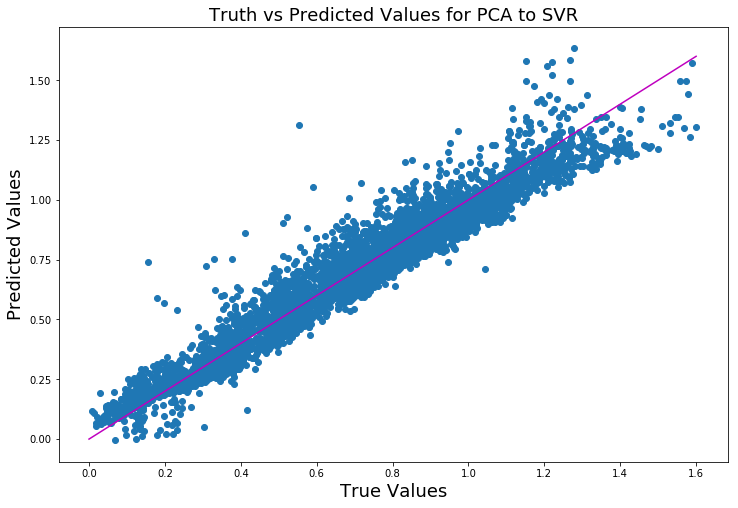

In [222]:
clf = SVR(kernel='rbf')
pca = PCA()

pipeline = Pipeline(steps=[('pca', pca), ('clf', clf)])
X = pd.concat([mags, magsErr, flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#scaler = StandardScaler()
#X_trainScale = pd.DataFrame(scaler.fit_transform(X_train))
#X_testScale = pd.DataFrame(scaler.fit_transform(X_test))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(pipeline.score(X_test, y_test))
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for PCA to SVR',fontsize=18)
plt.show()

0.5153342385884184


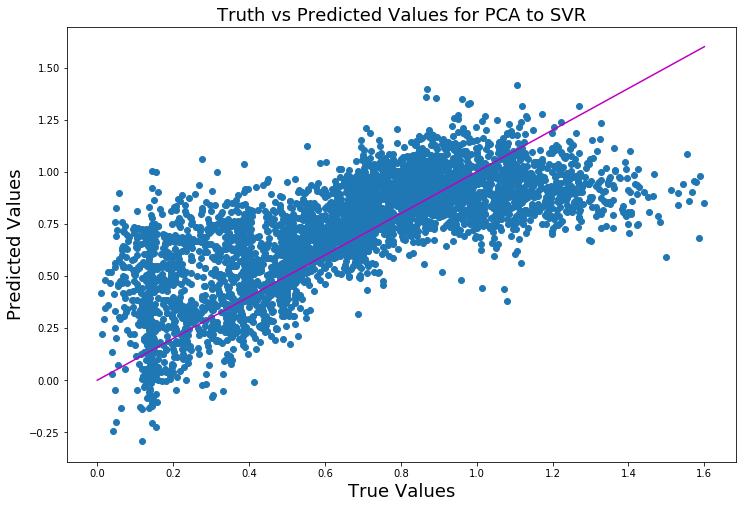

In [225]:
clf = SVR(kernel='rbf')
pca = PCA()

pipeline = Pipeline(steps=[('pca', pca), ('clf', clf)])
X = pd.concat([flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()
X_trainScale = pd.DataFrame(scaler.fit_transform(X_train))
X_testScale = pd.DataFrame(scaler.fit_transform(X_test))
pipeline.fit(X_trainScale, y_train)
y_pred = pipeline.predict(X_testScale)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for PCA to SVR',fontsize=18)
plt.show()

In [ ]:
#Try linear regression, lasso, and ridge regression

Training score for alpha=0.01:  -10403.48518746069
Test score:  -10309.071694841045
Number of features used: 2
-10309.071694841045


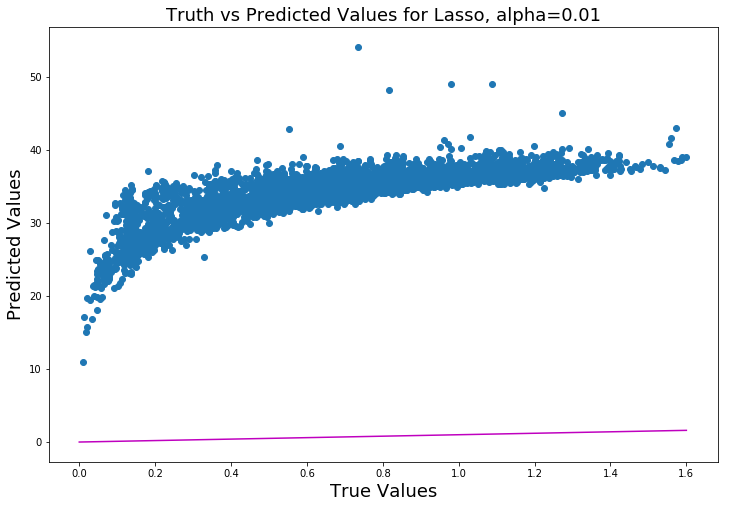

Training score for alpha=0.0001:  0.8047090839497072
Test score:  0.6047086115143819
Number of features used: 24
0.6047086115143819


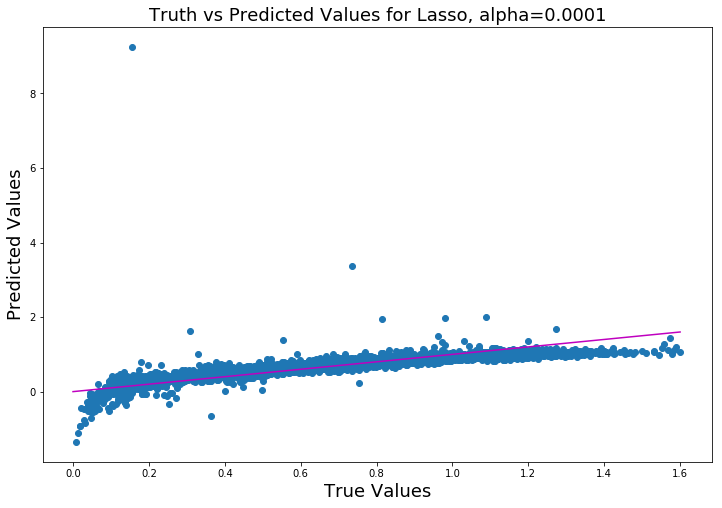

LR training score: 0.8215606588369416
LR test score:  0.6533140430087454
0.6533140430087454


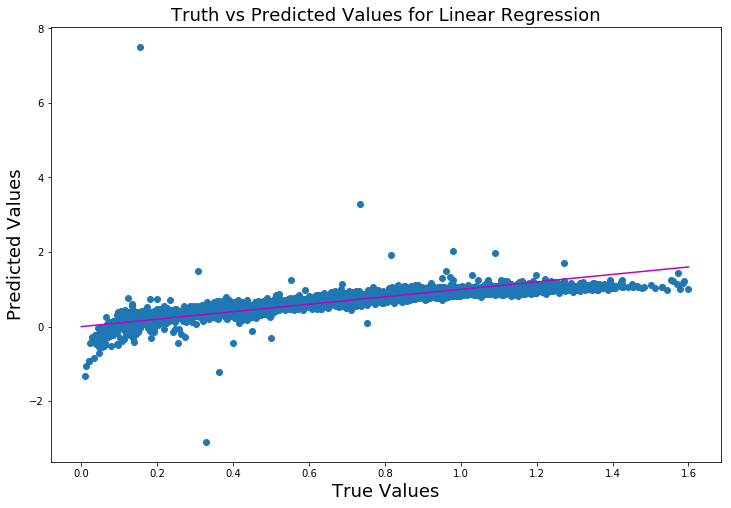

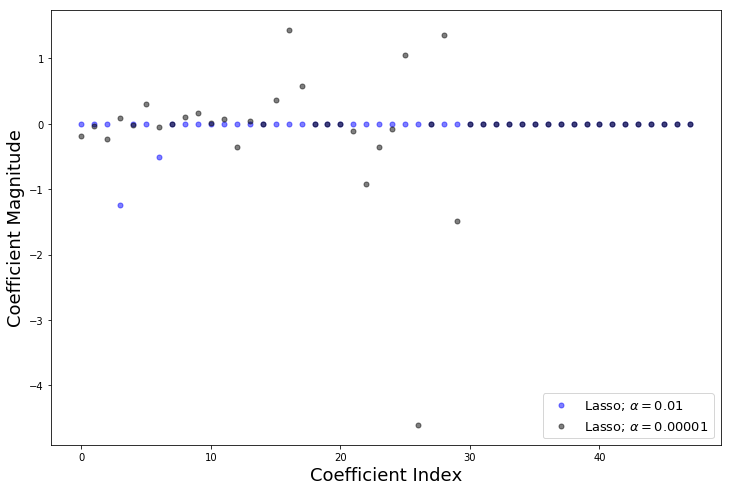

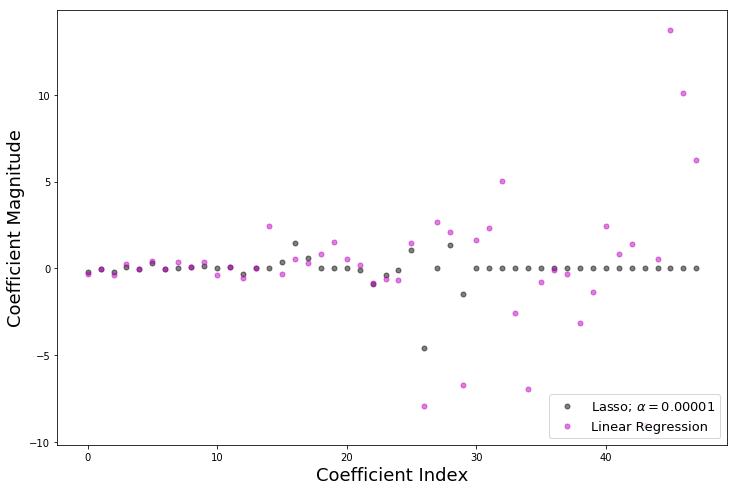

In [203]:
X = pd.concat([mags, magsErr, flux, fluxErr], axis=1, sort=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_trainScale,y_train)

train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print('Training score for alpha=0.01: ', train_score001)
print('Test score: ', test_score001)
print('Number of features used:', coeff_used001)

y_pred = lasso001.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Lasso, alpha=0.01',fontsize=18)
plt.show()

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)

train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print('Training score for alpha=0.0001: ', train_score00001)
print('Test score: ', test_score00001)
print('Number of features used:', coeff_used00001)

y_pred = lasso00001.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Lasso, alpha=0.0001',fontsize=18)
plt.show()

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)

print('LR training score:', lr_train_score)
print('LR test score: ', lr_test_score)

y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Linear Regression',fontsize=18)
plt.show()

plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='o',markersize=5,color='blue',label=r'Lasso; $\alpha = 0.01$')
plt.plot(lasso00001.coef_,alpha=0.5,linestyle='none',marker='o',markersize=5,color='black',label=r'Lasso; $\alpha = 0.00001$')
plt.xlabel('Coefficient Index',fontsize=18)
plt.ylabel('Coefficient Magnitude',fontsize=18)
plt.legend(fontsize=13,loc=4)
plt.show()

plt.plot(lasso00001.coef_,alpha=0.5,linestyle='none',marker='o',markersize=5,color='black',label=r'Lasso; $\alpha = 0.00001$') 
plt.plot(lr.coef_,alpha=0.5,linestyle='none',marker='o',markersize=5,color='m',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=18)
plt.ylabel('Coefficient Magnitude',fontsize=18)
plt.legend(fontsize=13,loc=4)
plt.show()

Training score for ridge regression, alpha=0.01:  0.8150156746210617
Testing score:  0.8111060753453952
0.8111060753453954


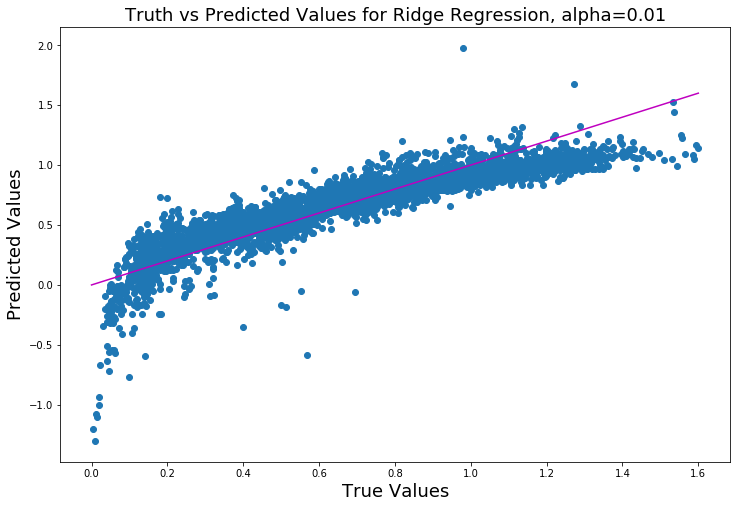

Training score for ridge regression, alpha=100:  0.8150156746210617
Testing score:  0.8111060753453952
0.7271493735462135


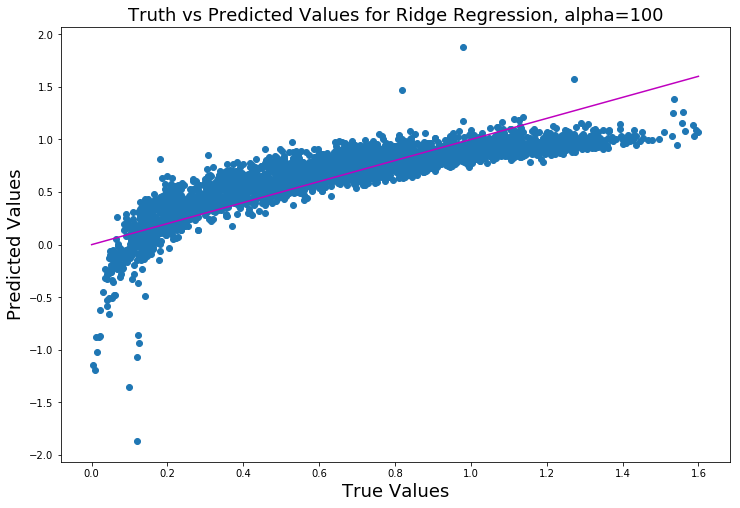

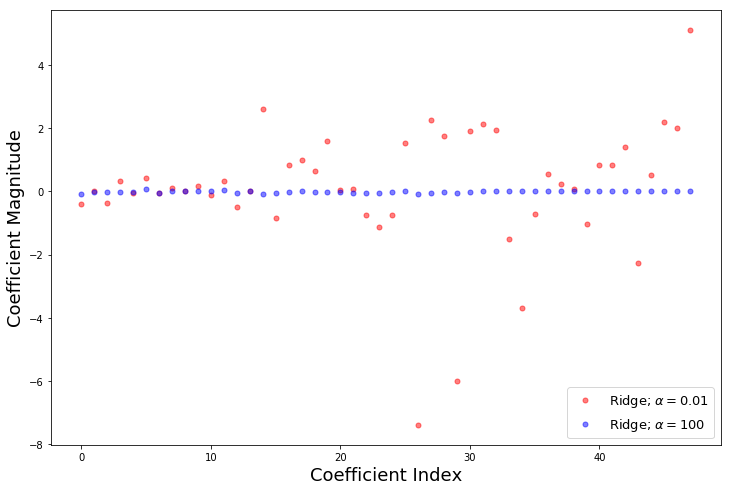

In [227]:
X = pd.concat([mags, magsErr, flux, fluxErr], axis=1, sort=False)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=3)

rr = Ridge(alpha=0.01) 
rr.fit(X_train, y_train)

rr100 = Ridge(alpha=100) 
rr100.fit(X_train, y_train)

ridge_train_score = rr.score(X_train,y_train)
ridge_test_score = rr.score(X_test, y_test)

ridge_train_score100 = rr100.score(X_train,y_train)
ridge_test_score100 = rr100.score(X_test, y_test)

print('Training score for ridge regression, alpha=0.01: ', Ridge_train_score)
print('Testing score: ', Ridge_test_score)
y_pred = rr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Ridge Regression, alpha=0.01',fontsize=18)
plt.show()

print('Training score for ridge regression, alpha=100: ', Ridge_train_score)
print('Testing score: ', Ridge_test_score)
y_pred = rr100.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
plt.scatter(y_test, y_pred)
plt.plot(np.arange(0,1.7,0.1), np.arange(0,1.7,0.1), color="m")
plt.xlabel('True Values',fontsize=18)
plt.ylabel('Predicted Values',fontsize=18)
plt.title('Truth vs Predicted Values for Ridge Regression, alpha=100',fontsize=18)
plt.show()

plt.plot(rr.coef_,alpha=0.5,linestyle='none',marker='o',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$')
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='o',markersize=5,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.xlabel('Coefficient Index',fontsize=18)
plt.ylabel('Coefficient Magnitude',fontsize=18)
plt.legend(fontsize=13,loc=4)
plt.show()

In [201]:
param_grid = {
    'alpha': [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
rr = Ridge(fit_intercept=True)
search = GridSearchCV(rr, param_grid, cv = 5, return_train_score = False)
search.fit(X,y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.704):
{'alpha': 0.01}


In [206]:
param_grid = {
    'alpha': [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
lasso = Lasso(max_iter=10e5)
search = GridSearchCV(lasso, param_grid, cv = 5, return_train_score = False)
search.fit(X,y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.712):
{'alpha': 1e-05}
